# Lab 13: Deep RL

exploring deep reinforcement learning with policy gradient
and actor-critic approaches.
Here are some of the references used in today's lab:

- https://gym.openai.com
- Deep Reinforcement Learning Hands-On (Packtpub)
- https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py
- https://towardsdatascience.com/breaking-down-richard-suttons-policy-gradient-9768602cb63b
- https://towardsdatascience.com/learning-reinforcement-learning-reinforce-with-pytorch-5e8ad7fc7da0
- https://github.com/woithook/A2C-Pytorch-implementations

In [1]:
id = 123012
name ='Todsavad Tangtortan'

# Take-home exercise

Implement REINFORCE and A2C for one of the Atari games such as Space Invaders using a CNN for the policy
network and (for A2C) the value network.

## Setting Environment

In [6]:
# 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' 
# mkdir ~/.mujoco
# wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
# rm mujoco.tar.gz
# pip install mujoco-py
# pip install gymnasium[mujoco]
# pip install gymnasium[classic-control]
# apt-get install libglew-dev patchelf libosmesa6-dev libgl1-mesa-glx
# apt-get install -y xvfb python-opengl 
# xvfb-run -a -s "-screen 0 1400x900x24" bash

## REINFORCE

In [2]:
# Gym is an OpenAI toolkit for RL
from gymnasium.spaces import Box
from gymnasium.wrappers import FrameStack
import gymnasium as gym

import torch
import torch.nn as nn
from torch import optim
from torch.distributions import Categorical
import torch.autograd as autograd 
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
import matplotlib.pyplot as plt

import numpy as np
from utils import GrayScaleObservation, ResizeObservation, SkipFrame

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Policy(nn.Module):
    def __init__(self, env):
        super(Policy, self).__init__()
        # self.n_inputs = env.observation_space.shape[2]
        self.n_outputs = env.action_space.n

        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)
        
        self.affine1 = nn.Linear(4096, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, self.n_outputs)

        self.saved_log_probs = []
        self.rewards = []
    
    def forward(self, x):
        x = x / 255.0  # normalize pixel values
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, state):
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
        probs = self.forward(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()

In [4]:
#RL environment parameters
gamma = 0.95
seed = 0
render = False
log_interval = 10

env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
# define a reward threshold
reward_threshold = 300
# register the reward threshold with the environment
env.spec.reward_threshold = reward_threshold
# env = gym.make("SpaceInvaders-v0")
env = FrameStack(ResizeObservation(GrayScaleObservation(SkipFrame(env, skip=4)), shape=84), num_stack=4)
env.reset(seed=seed)
torch.manual_seed(seed)

#Create out policy Network
policy = Policy(env)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [5]:
def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

from itertools import count
def reinforce():
    running_reward = 10
    for i_episode in count(1):
        (state, info), ep_reward = env.reset(), 0
        # print('Initial State', state)
        for t in range(1, 10000):  # Don't infinite loop while learning
            action = policy.select_action(state)
            state, reward, done, truncated, info = env.step(action)
            # print('New State', state)
            if render:
                env.render()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # calculate reward
        # It accepts a list of rewards for the whole episode and needs to calculate 
        # the discounted total reward for every step. To do this efficiently,
        # we calculate the reward from the end of the local reward list.
        # The last step of the episode will have the total reward equal to its local reward.
        # The step before the last will have the total reward of ep_reward + gamma * running_reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        finish_episode()
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))

        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

In [6]:
reinforce()
env.close()

Episode 10	Last reward: 180.00	Average reward: 95.77
Episode 20	Last reward: 285.00	Average reward: 181.60
Episode 30	Last reward: 485.00	Average reward: 244.85
Episode 40	Last reward: 220.00	Average reward: 267.49
Episode 50	Last reward: 135.00	Average reward: 242.66
Episode 60	Last reward: 155.00	Average reward: 243.16
Episode 70	Last reward: 135.00	Average reward: 207.00
Episode 80	Last reward: 85.00	Average reward: 190.89
Episode 90	Last reward: 290.00	Average reward: 178.00
Episode 100	Last reward: 65.00	Average reward: 139.06
Episode 110	Last reward: 125.00	Average reward: 129.55
Episode 120	Last reward: 305.00	Average reward: 130.85
Episode 130	Last reward: 175.00	Average reward: 135.96
Episode 140	Last reward: 70.00	Average reward: 142.77
Episode 150	Last reward: 110.00	Average reward: 125.79
Episode 160	Last reward: 45.00	Average reward: 122.52
Episode 170	Last reward: 15.00	Average reward: 94.65
Episode 180	Last reward: 125.00	Average reward: 118.72
Episode 190	Last reward: 3

## Policy Gradient

In [8]:
# Gym is an OpenAI toolkit for RL
from gymnasium.spaces import Box
from gymnasium.wrappers import FrameStack
import gymnasium as gym

import torch
import torch.nn as nn
from torch import optim
from torch.distributions import Categorical
import torch.autograd as autograd 
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
import matplotlib.pyplot as plt

import numpy as np
from utils import GrayScaleObservation, ResizeObservation, SkipFrame
from tqdm import tqdm

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(PolicyNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)

        self.fc1 = torch.nn.Linear(4096, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = x / 255.0  # normalize pixel values
        x = torch.from_numpy(x).float().unsqueeze(0)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        return self.softmax(self.fc2(torch.nn.functional.relu(self.fc1(x))))

    def get_action_and_logp(self, x):
        x = x.__array__()/255.0
        action_prob = self.forward(x)
        m = torch.distributions.Categorical(action_prob)
        action = m.sample()
        logp = m.log_prob(action)
        return action.item(), logp

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action


class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(ValueNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)

        self.fc1 = torch.nn.Linear(4096, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = x.__array__() / 255.0  # normalize pixel values
        x = torch.from_numpy(x).float().unsqueeze(0)

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        return self.fc2(torch.nn.functional.relu(self.fc1(x)))

In [3]:
def vpg(env, num_iter=200, num_traj=10, max_num_steps=1000, gamma=0.98,
        policy_learning_rate=0.01, value_learning_rate=0.01,
        policy_saved_path='vpg_policy_invader.pt', value_saved_path='vpg_value_invader.pt'):
    input_size = env.observation_space.shape[0] # Box(3,210,160)
    output_size = env.action_space.n
    print(f'input_size {input_size}')
    print(f'output_size {output_size} actions')
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')

    def collect_trajectory():
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state, info = env.reset()
        done = False
        steps = 0
        while not done and steps <= max_num_steps:
            action, logp = policy.get_action_and_logp(state)
            newstate, reward, done, truncated, info = env.step(action)
            #reward = reward + float(state[0])
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate

        traj = Trajectory(states=state_list, actions=action_list,
                          rewards=reward_list, logp=logp_list, dones=dones_list)
        return traj

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]

    policy = PolicyNet(input_size, output_size)
    value = ValueNet(input_size)
    policy_optimizer = torch.optim.Adam(
        policy.parameters(), lr=policy_learning_rate)
    value_optimizer = torch.optim.Adam(
        value.parameters(), lr=value_learning_rate)

    mean_return_list = []
    for it in tqdm(range(num_iter)):
        traj_list = [collect_trajectory() for _ in range(num_traj)]
        returns = [calc_returns(traj.rewards) for traj in traj_list]

        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))
                             for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * \
            sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))
            torch.save(policy.state_dict(), policy_saved_path)
            torch.save(value.state_dict(), value_saved_path)
    return policy, mean_return_list

In [4]:
env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
env = FrameStack(ResizeObservation(GrayScaleObservation(SkipFrame(env, skip=4)), shape=84), num_stack=4)

agent, mean_return_list = vpg(env, num_iter=200, max_num_steps=500, gamma=1.0,
                              num_traj=5)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


input_size 4
output_size 6 actions


  0%|          | 1/200 [00:11<36:35, 11.03s/it]

Iteration 0: Mean Return = 136.0


  6%|▌         | 11/200 [02:00<35:14, 11.19s/it]

Iteration 10: Mean Return = 183.0


 10%|█         | 21/200 [03:54<34:27, 11.55s/it]

Iteration 20: Mean Return = 190.0


 16%|█▌        | 31/200 [05:47<29:52, 10.60s/it]

Iteration 30: Mean Return = 135.0


 20%|██        | 41/200 [07:41<30:17, 11.43s/it]

Iteration 40: Mean Return = 132.0


 26%|██▌       | 51/200 [09:31<27:46, 11.18s/it]

Iteration 50: Mean Return = 164.0


 30%|███       | 61/200 [11:20<24:17, 10.48s/it]

Iteration 60: Mean Return = 70.0


 36%|███▌      | 71/200 [13:15<25:59, 12.09s/it]

Iteration 70: Mean Return = 216.0


 40%|████      | 81/200 [15:17<24:27, 12.33s/it]

Iteration 80: Mean Return = 190.0


 46%|████▌     | 91/200 [17:09<20:46, 11.43s/it]

Iteration 90: Mean Return = 142.0


 50%|█████     | 101/200 [18:57<18:24, 11.15s/it]

Iteration 100: Mean Return = 81.0


 56%|█████▌    | 111/200 [20:58<16:25, 11.07s/it]

Iteration 110: Mean Return = 75.0


 60%|██████    | 121/200 [23:01<15:48, 12.00s/it]

Iteration 120: Mean Return = 90.0


 66%|██████▌   | 131/200 [24:48<12:37, 10.98s/it]

Iteration 130: Mean Return = 151.0


 70%|███████   | 141/200 [26:45<11:33, 11.75s/it]

Iteration 140: Mean Return = 179.0


 76%|███████▌  | 151/200 [28:39<09:52, 12.09s/it]

Iteration 150: Mean Return = 179.0


 80%|████████  | 161/200 [30:24<06:37, 10.20s/it]

Iteration 160: Mean Return = 123.0


 86%|████████▌ | 171/200 [32:10<05:30, 11.38s/it]

Iteration 170: Mean Return = 167.0


 90%|█████████ | 181/200 [34:02<03:43, 11.78s/it]

Iteration 180: Mean Return = 254.0


 96%|█████████▌| 191/200 [36:03<01:54, 12.68s/it]

Iteration 190: Mean Return = 160.0


100%|██████████| 200/200 [37:46<00:00, 11.33s/it]


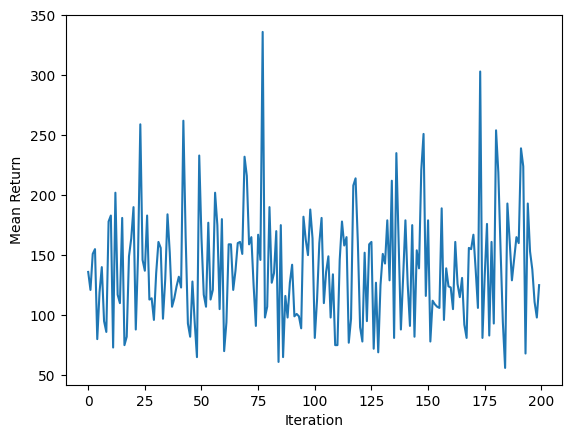

In [7]:
plt.plot(mean_return_list)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('vpg_returns.png', format='png', dpi=300)

In [10]:
# state,_  = env.reset()
# for t in range(1000):
#     action = agent.act(state)
#     env.render()
#     state, reward, done, truncated, info  = env.step(action)
#     if done:
#         break
# env.close()

## Actor-Critic

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gymnasium as gym
from gym.wrappers import RecordVideo
from utils import GrayScaleObservation, ResizeObservation, SkipFrame
from gymnasium.spaces import Box
from gymnasium.wrappers import FrameStack
from tqdm import tqdm

In [17]:
class ActorNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)

        self.fc1 = nn.Linear(4096,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,action_size)

    def forward(self,x):

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        return out

class ValueNetwork(nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)

        self.fc1 = nn.Linear(4096,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)

    def forward(self,x):

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
    
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [18]:
def roll_out(actor_network,task,sample_nums,value_network,init_state):
    #task.reset()
    states = []
    actions = []
    rewards = []
    is_done = False
    final_r = 0
    state = init_state

    for j in range(sample_nums):
        states.append(np.array(state))
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
        log_softmax_action = actor_network(state)
        softmax_action = torch.exp(log_softmax_action)
        action = np.random.choice(ACTION_DIM,p=softmax_action.cpu().data.numpy()[0])
        one_hot_action = [int(k == action) for k in range(ACTION_DIM)]
        next_state,reward,done,_,_ = task.step(action)
        #fix_reward = -10 if done else 1
        actions.append(one_hot_action)
        rewards.append(reward)
        final_state = next_state
        state = next_state
        if done:
            is_done = True
            state, _ = task.reset()
            break
    if not is_done:
        final_state = torch.from_numpy(np.array(final_state)).float().unsqueeze(0)
        final_r = value_network(final_state).cpu().data.numpy()

    return states,actions,rewards,final_r,state

def discount_reward(r, gamma,final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [19]:
def A2C():
    # init a task generator for data fetching
    # task = gym.make("CartPole-v1")
    env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
    task = FrameStack(ResizeObservation(GrayScaleObservation(SkipFrame(env, skip=4)), shape=84), num_stack=4)
    input_size = task.observation_space.shape[0]
    init_state, _ = task.reset()

    # init value network
    value_network = ValueNetwork(input_size = input_size, hidden_size = 40,output_size = 1)
    value_network_optim = torch.optim.Adam(value_network.parameters(),lr=0.01)

    # init actor network
    actor_network = ActorNetwork(input_size,40,ACTION_DIM)
    actor_network_optim = torch.optim.Adam(actor_network.parameters(),lr = 0.01)

    steps =[]
    task_episodes =[]
    test_results =[]

    for step in tqdm(range(STEP)):
        states, actions,rewards,final_r,current_state = roll_out(actor_network,task,SAMPLE_NUMS,value_network,init_state)
        init_state = current_state
        actions_var = torch.Tensor(actions)
        states_var = torch.Tensor(states)

        # train actor network
        actor_network_optim.zero_grad()
        log_softmax_actions = actor_network(states_var)
        vs = value_network(states_var).detach()
        # calculate qs
        qs = torch.Tensor(discount_reward(rewards,0.99,final_r))

        advantages = qs - vs
        actor_network_loss = - torch.mean(torch.sum(log_softmax_actions*actions_var,1)* advantages)
        actor_network_loss.backward()
        torch.nn.utils.clip_grad_norm(actor_network.parameters(),0.5)
        actor_network_optim.step()

        # train value network
        value_network_optim.zero_grad()
        target_values = qs.unsqueeze(1)
        values = value_network(states_var)
        criterion = nn.MSELoss()
        value_network_loss = criterion(values,target_values)
        value_network_loss.backward()
        torch.nn.utils.clip_grad_norm(value_network.parameters(),0.5)
        value_network_optim.step()

        # Testing
        if (step + 1) % 50== 0:
                result = 0
                # test_task = gym.make("CartPole-v1")
                env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
                test_task = FrameStack(ResizeObservation(GrayScaleObservation(SkipFrame(env, skip=4)), shape=84), num_stack=4)
                for test_epi in range(10):
                    state, _ = test_task.reset()
                    for test_step in range(200):
                        # print(state)
                        state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
                        softmax_action = torch.exp(actor_network(state))
                        #print(softmax_action.data)
                        action = np.argmax(softmax_action.data.numpy()[0])
                        next_state,reward,done,_,_ = test_task.step(action)
                        result += reward
                        state = next_state
                        if done:
                            break
                print("step:",step+1,"test result:",result/10.0)
                steps.append(step+1)
                test_results.append(result/10)
                
    return actor_network

In [20]:
# Hyper Parameters
STATE_DIM = 4
ACTION_DIM = 6
STEP = 2000
SAMPLE_NUMS = 30

actor_network = A2C()

# vdo_path = 'video_rl3/'
# if not os.path.exists(vdo_path):
#     os.mkdir(vdo_path)

# # env = RecordVideo(gym.make("CartPole-v1"), vdo_path)
# env = gym.make("ALE/SpaceInvaders-v5", render_mode="rgb_array")
# env = FrameStack(ResizeObservation(GrayScaleObservation(SkipFrame(env, skip=4)), shape=84), num_stack=4)

# state,_ = env.reset()
# for t in range(1000):
#     state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
#     softmax_action = torch.exp(actor_network(state))
#     #print(softmax_action.data)
#     action = np.argmax(softmax_action.data.numpy()[0])
#     env.render()
#     state, reward, done, _, _ = env.step(action)
#     if done:
#         break
# env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_7245/547364578.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc3(out))
/tmp/ipykernel_7245/3431494964.py:37: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(actor_network.parameters(),0.5)
/tmp/ipykernel_7245/3431494964.py:47: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(value_network.parameters(),0.5)
  2%|▎         | 50/2000 [00:32<1:52:11,  3.45s/it]

step: 50 test result: 285.0


  5%|▌         | 100/2000 [01:04<1:55:52,  3.66s/it]

step: 100 test result: 285.0


  8%|▊         | 150/2000 [01:36<1:58:32,  3.84s/it]

step: 150 test result: 285.0


 10%|█         | 200/2000 [02:08<2:00:11,  4.01s/it]

step: 200 test result: 285.0


 12%|█▎        | 250/2000 [02:40<1:55:03,  3.95s/it]

step: 250 test result: 285.0


 15%|█▌        | 300/2000 [03:12<1:57:15,  4.14s/it]

step: 300 test result: 285.0


 18%|█▊        | 350/2000 [03:45<1:28:13,  3.21s/it]

step: 350 test result: 285.0


 20%|██        | 400/2000 [04:17<1:33:33,  3.51s/it]

step: 400 test result: 285.0


 22%|██▎       | 450/2000 [04:49<1:33:14,  3.61s/it]

step: 450 test result: 285.0


 25%|██▌       | 500/2000 [05:22<1:36:34,  3.86s/it]

step: 500 test result: 285.0


 28%|██▊       | 550/2000 [05:55<1:36:21,  3.99s/it]

step: 550 test result: 285.0


 30%|███       | 600/2000 [06:27<1:37:33,  4.18s/it]

step: 600 test result: 285.0


 32%|███▎      | 650/2000 [06:59<1:29:53,  4.00s/it]

step: 650 test result: 285.0


 35%|███▌      | 700/2000 [07:31<1:08:11,  3.15s/it]

step: 700 test result: 285.0


 38%|███▊      | 750/2000 [08:03<1:13:41,  3.54s/it]

step: 750 test result: 285.0


 40%|████      | 800/2000 [08:35<1:11:58,  3.60s/it]

step: 800 test result: 285.0


 42%|████▎     | 850/2000 [09:07<1:15:32,  3.94s/it]

step: 850 test result: 285.0


 45%|████▌     | 900/2000 [09:40<1:13:48,  4.03s/it]

step: 900 test result: 285.0


 48%|████▊     | 950/2000 [10:12<1:12:19,  4.13s/it]

step: 950 test result: 285.0


 50%|█████     | 1000/2000 [10:44<1:07:48,  4.07s/it]

step: 1000 test result: 285.0


 52%|█████▎    | 1050/2000 [11:17<50:19,  3.18s/it]  

step: 1050 test result: 285.0


 55%|█████▌    | 1100/2000 [11:49<50:54,  3.39s/it]

step: 1100 test result: 285.0


 57%|█████▊    | 1150/2000 [12:20<50:09,  3.54s/it]

step: 1150 test result: 285.0


 60%|██████    | 1200/2000 [12:52<50:33,  3.79s/it]

step: 1200 test result: 285.0


 62%|██████▎   | 1250/2000 [13:24<49:28,  3.96s/it]

step: 1250 test result: 285.0


 65%|██████▌   | 1300/2000 [13:56<46:50,  4.01s/it]

step: 1300 test result: 285.0


 68%|██████▊   | 1350/2000 [14:29<44:24,  4.10s/it]

step: 1350 test result: 285.0


 70%|███████   | 1400/2000 [15:02<32:43,  3.27s/it]

step: 1400 test result: 285.0


 72%|███████▎  | 1450/2000 [15:34<32:24,  3.53s/it]

step: 1450 test result: 285.0


 75%|███████▌  | 1500/2000 [16:06<30:15,  3.63s/it]

step: 1500 test result: 285.0


 78%|███████▊  | 1550/2000 [16:38<28:53,  3.85s/it]

step: 1550 test result: 285.0


 80%|████████  | 1600/2000 [17:10<26:48,  4.02s/it]

step: 1600 test result: 285.0


 82%|████████▎ | 1650/2000 [17:42<23:12,  3.98s/it]

step: 1650 test result: 285.0


 85%|████████▌ | 1700/2000 [18:14<19:06,  3.82s/it]

step: 1700 test result: 285.0


 88%|████████▊ | 1750/2000 [18:46<13:55,  3.34s/it]

step: 1750 test result: 285.0


 90%|█████████ | 1800/2000 [19:19<11:49,  3.55s/it]

step: 1800 test result: 285.0


 92%|█████████▎| 1850/2000 [19:51<09:04,  3.63s/it]

step: 1850 test result: 285.0


 95%|█████████▌| 1900/2000 [20:23<06:34,  3.95s/it]

step: 1900 test result: 285.0


 98%|█████████▊| 1950/2000 [20:55<03:12,  3.84s/it]

step: 1950 test result: 285.0


100%|██████████| 2000/2000 [21:27<00:00,  1.55it/s]

step: 2000 test result: 285.0


ValueError: only one element tensors can be converted to Python scalars

## Conclusion

In Atari environments, Space Invader return Actions are 6 and Observation Space (210, 160, 3) which refer to width, heihgt, channels. 
Firstly, frames was skipping by 4 frames. Furthermore, changing it to greyscale then resize from (3, 210, 160) to (4, 84, 84) instead.
Each model has added convoluton layers.

        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=1)

        self.fc1 = torch.nn.Linear(4096, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)
        
In 1st model, REINFORCE was set reward_threshold = 300 Therefore, Running reward is now 307.94 and the last episode runs to 260 time steps!

In 2nd model, Policy Gradient was tested 200 iteration and the maximum mean return is 254.0

In 3rd model, Actor-Critic was tested 2000 iteration as well and the result reach to 285.0